In [4]:
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Activation
import pandas as pd
import os
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")
import json

In [79]:
from tqdm import tqdm

In [14]:
def create_xtest(data,n_predictions,n_next):
    """
    创建测试集
    """
    test_X = []
    for i in range(data.shape[0] - n_predictions - n_next + 1):
        a = data[(i + n_predictions - n_next ):(i +  (2 * n_predictions) - n_next),:]
        test_X.append(a)
    test_X = np.array(test_X,dtype='float64')
    return test_X

In [15]:
def Y_to_seq(Y):
    seq = []
    for i in range(Y.shape[0]):
        seq.append(Y[i,0])
    for i in range(1,Y.shape[1]):
        seq.append(Y[-1,i])
    return np.array(seq)

In [16]:
def create_dataset(data,n_predictions,n_next):
    '''
    对数据进行处理
    '''
    dim = data.shape[1]
    train_X, train_Y = [], []
    for i in range(data.shape[0]-n_predictions-n_next+1):
        a = data[i:(i+n_predictions),:]
        train_X.append(a)
        tempb = data[(i+n_predictions):(i+n_predictions+n_next),:]
        b = []
        for j in range(len(tempb)):
            for k in range(dim):
                b.append(tempb[j,k])
        train_Y.append(b)
    train_X = np.array(train_X,dtype='float64')
    train_Y = np.array(train_Y,dtype='float64')

    return train_X, train_Y
def trainModel(train_X, train_Y):
    '''
    trainX，trainY: 训练LSTM模型所需要的数据
    '''
    model = Sequential()
    model.add(LSTM(
        140,
        input_shape=(train_X.shape[1], train_X.shape[2]),
        return_sequences=True))
    model.add(Dropout(0.3))

    model.add(LSTM(
        140,
        return_sequences=False))
    model.add(Dropout(0.3))

    model.add(Dense(
        train_Y.shape[1]))
    model.add(Activation("relu"))

    model.compile(loss='mse', optimizer='adam')
    model.fit(train_X, train_Y, epochs=200, batch_size=64, verbose=1)

    return model
def reshape_y_hat(y_hat,dim):
    re_y = np.zeros(len(y_hat),dtype='float64')
    length =int(len(y_hat)/dim)
    re_y = re_y.reshape(length,dim)

    for curdim in range(dim):
        for i in range(length):
            re_y[i,curdim] = y_hat[i + curdim*length]

    return  re_y

In [75]:
with open('change_flow.json','r') as f:
    dataset = json.load(f)

In [69]:
data = pd.DataFrame(dataset['3']).T
data = data.values
data = data.astype('float32')

In [70]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data.ravel().reshape(-1,1)).reshape(-1,1)

In [71]:
Xtrain,Ytrain = create_dataset(data,48,24)
Xtest = create_xtest(data,48,24)

In [72]:
model = trainModel(Xtrain,Ytrain)

In [73]:
y_hat = model.predict(Xtest)
Ytrain = scaler.inverse_transform(Ytrain)
Ypre = scaler.inverse_transform(y_hat)
data = scaler.inverse_transform(data)
Y_output = Y_to_seq(Ypre)

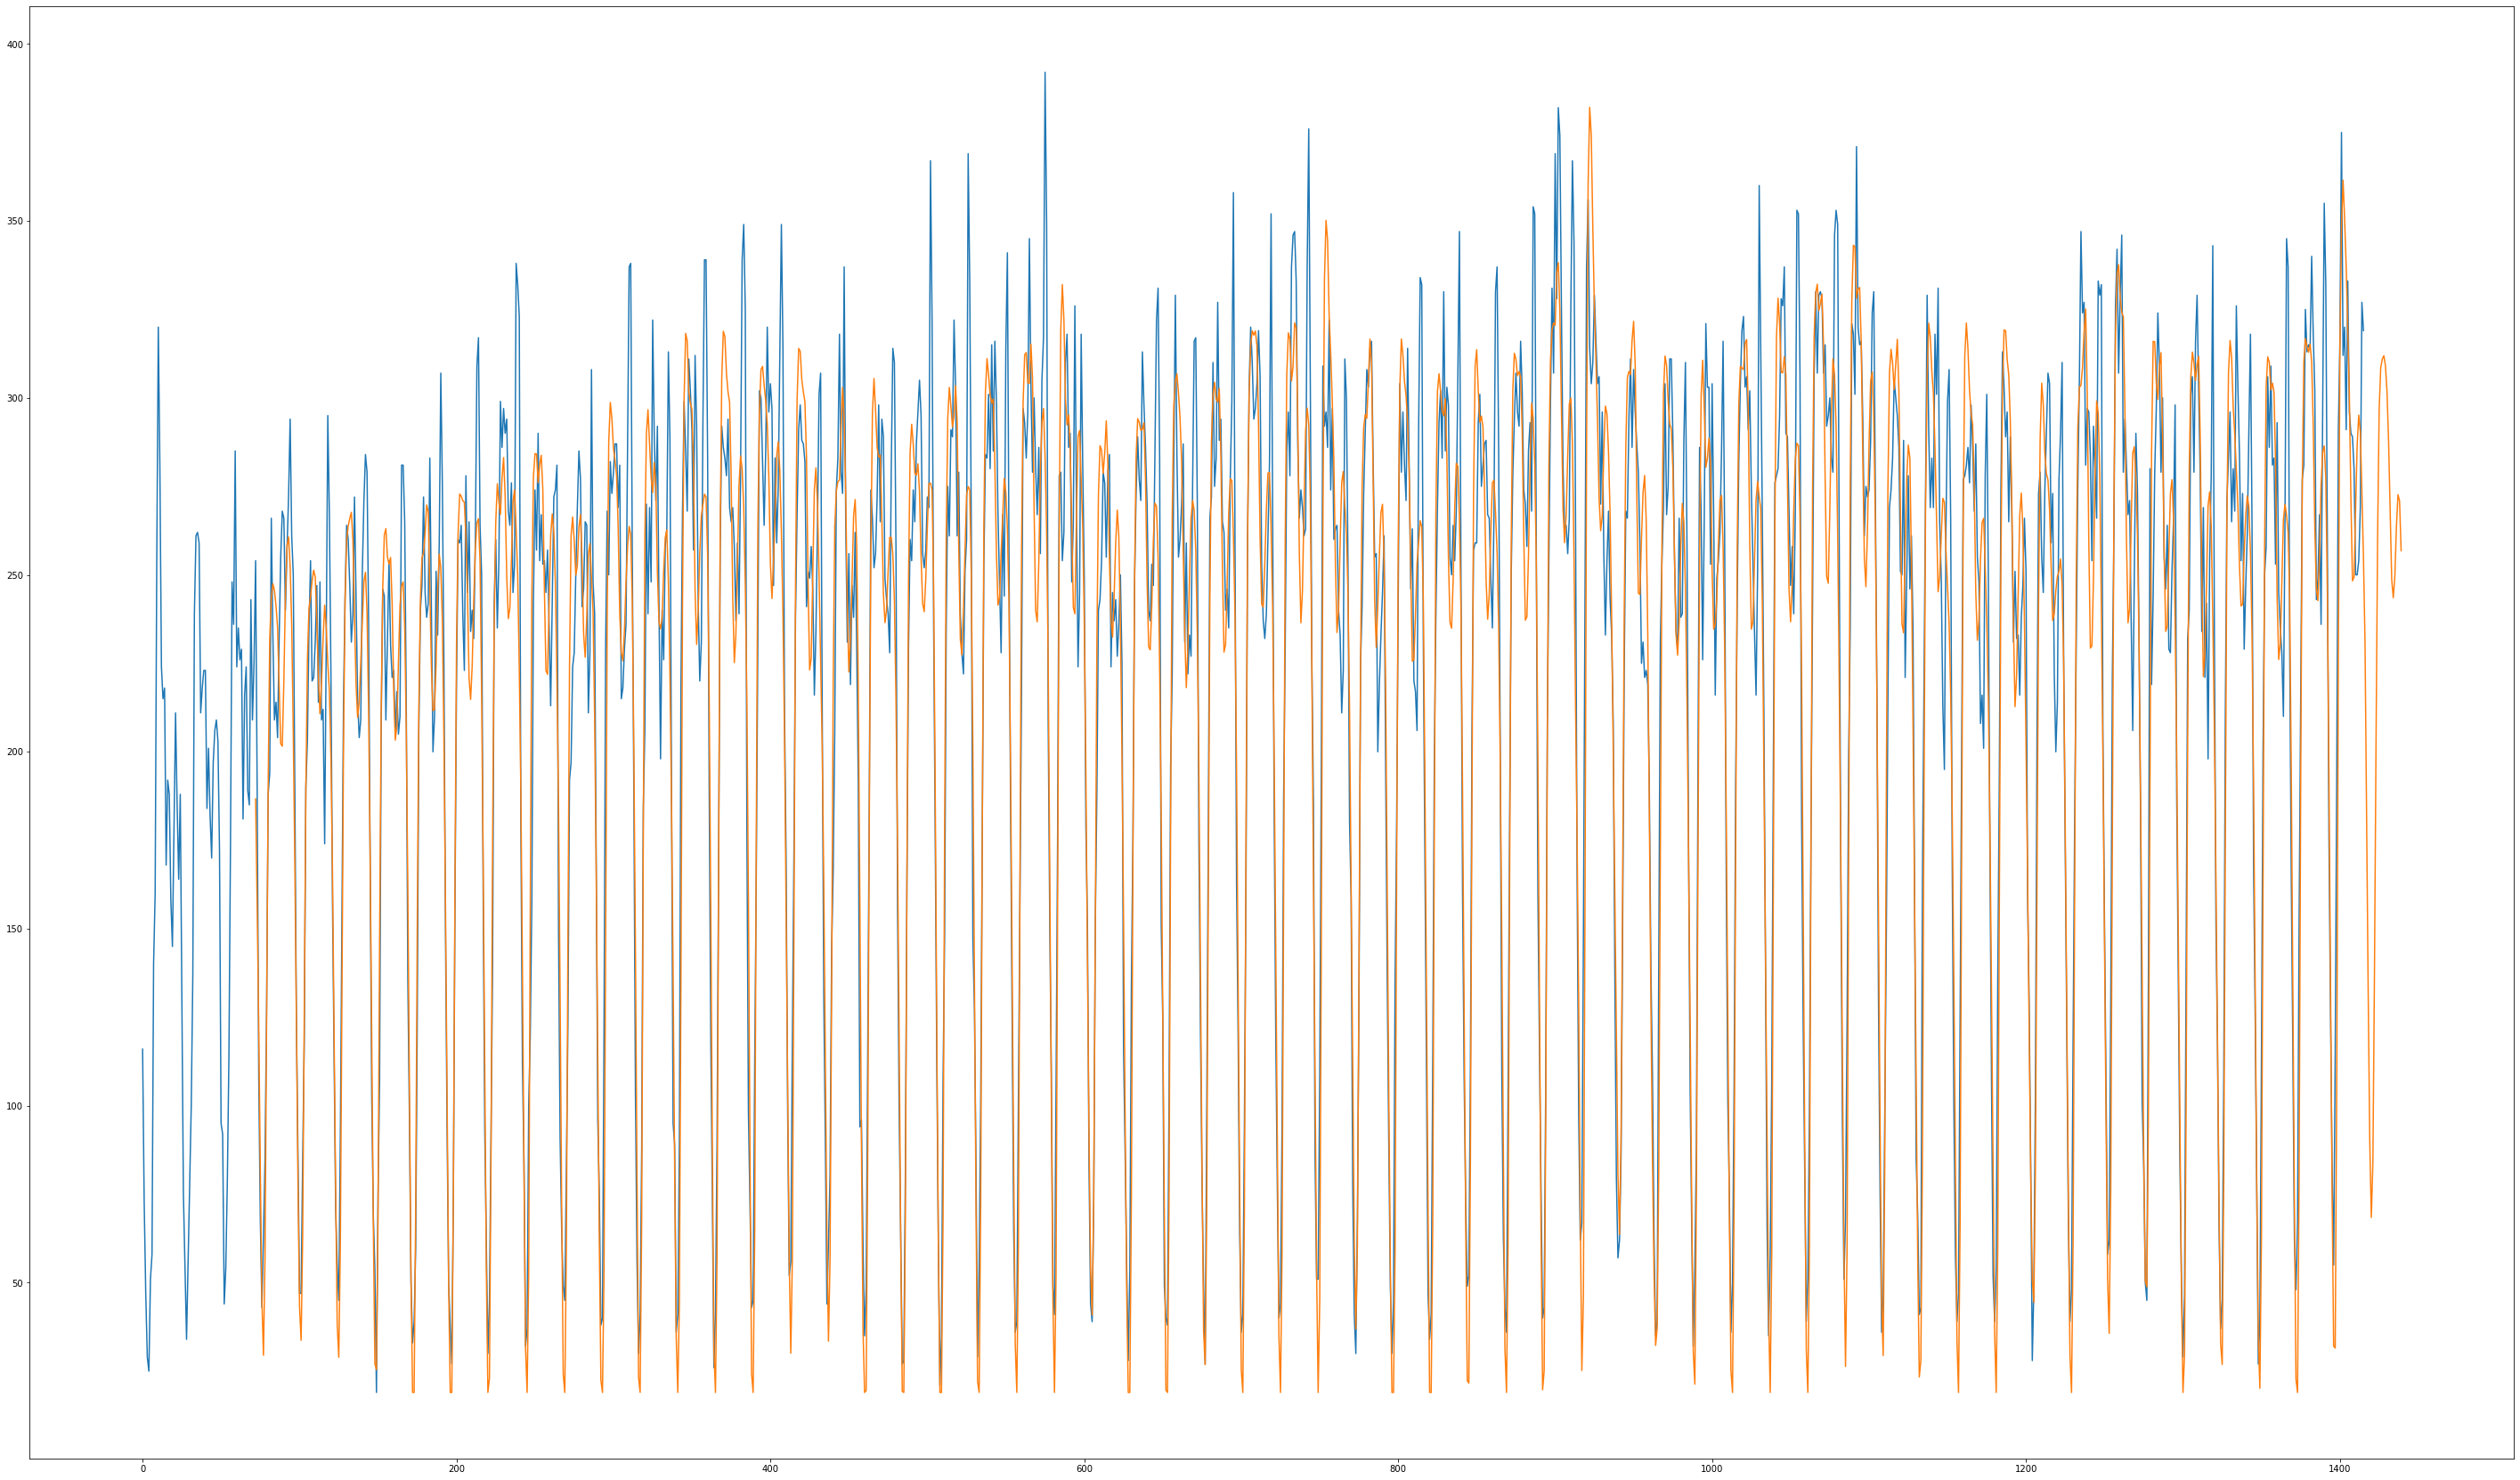

In [74]:
fig, ax = plt.subplots(figsize=(50,30))
x1 = range(data.shape[0])
x2 = range(3*24,Y_output.shape[0]+3*24)
plt.plot(x1,data)
plt.plot(x2,Y_output)
plt.show()

In [46]:
Y_output[-24:]

array([2828.025  , 2203.273  , 1538.9238 ,  877.5277 ,  312.35495,
        271.     ,  976.10657, 2083.886  , 3045.4844 , 3552.0627 ,
       3635.2263 , 3525.3984 , 3508.0493 , 3559.5154 , 3631.4612 ,
       3412.631  , 2950.9385 , 2480.2085 , 2308.1182 , 2464.0688 ,
       2813.0056 , 3187.0325 , 3373.7207 , 3262.4558 ], dtype=float32)

In [81]:
flow = {}
for i in tqdm(range(10)):
    flow[i] = {}
    data = pd.DataFrame(dataset[str(i)]).T
    data = data.values
    data = data.astype('float32')
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data.ravel().reshape(-1,1)).reshape(-1,1)
    Xtrain,Ytrain = create_dataset(data,48,24)
    Xtest = create_xtest(data,48,24)
    model = trainModel(Xtrain,Ytrain)
    y_hat = model.predict(Xtest)
    Ypre = scaler.inverse_transform(y_hat)
    Y_output = Y_to_seq(Ypre)
    y = Y_output[-24:]
    for j in range(24):
        flow[i][j+1] = y[j]

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Epoch 1/200
1345/1345 [==============================] - 5s 3ms/sample - loss: 0.1601
Epoch 2/200
1345/1345 [==============================] - 3s 2ms/sample - loss: 0.0884
Epoch 3/200
1345/1345 [==============================] - 3s 2ms/sample - loss: 0.0794
Epoch 4/200
1345/1345 [==============================] - 3s 2ms/sample - loss: 0.0622
Epoch 5/200
1345/1345 [==============================] - 3s 2ms/sample - loss: 0.0482
Epoch 6/200
1345/1345 [==============================] - 3s 2ms/sample - loss: 0.0414
Epoch 7/200
1345/1345 [==============================] - 3s 2ms/sample - loss: 0.0406
Epoch 8/200
1345/1345 [==============================] - 3s 2ms/sample - loss: 0.0358
Epoch 9/200
1345/1345 [==============================] - 3s 2ms/sample - loss: 0.0330
Epoch 10/200
1345/1345 [==============================] - 3s 2ms/sample - loss: 0.0275
Epoch 11/200
1345/1345 [==============================] - 3s 2ms/sample - loss: 0.0215
Epoch 12/200
1345/1345 [============================

 10%|████████                                                                        | 1/10 [13:27<2:01:09, 807.74s/it]

Epoch 1/200
1345/1345 [==============================] - 6s 5ms/sample - loss: 0.1558
Epoch 2/200
1345/1345 [==============================] - 5s 4ms/sample - loss: 0.0813
Epoch 3/200
1345/1345 [==============================] - 5s 4ms/sample - loss: 0.0681
Epoch 4/200
1345/1345 [==============================] - 5s 4ms/sample - loss: 0.0435
Epoch 5/200
1345/1345 [==============================] - 5s 4ms/sample - loss: 0.0375
Epoch 6/200
1345/1345 [==============================] - 5s 4ms/sample - loss: 0.0351
Epoch 7/200
1345/1345 [==============================] - 5s 4ms/sample - loss: 0.0335
Epoch 8/200
1345/1345 [==============================] - 5s 4ms/sample - loss: 0.0300
Epoch 9/200
1345/1345 [==============================] - 5s 4ms/sample - loss: 0.0259
Epoch 10/200
1345/1345 [==============================] - 5s 4ms/sample - loss: 0.0298
Epoch 11/200
1345/1345 [==============================] - 5s 4ms/sample - loss: 0.0215
Epoch 12/200
1345/1345 [============================

 20%|████████████████                                                                | 2/10 [29:59<2:02:06, 915.85s/it]

Epoch 1/200
1345/1345 [==============================] - 7s 5ms/sample - loss: 0.1070
Epoch 2/200
1345/1345 [==============================] - 5s 4ms/sample - loss: 0.0509
Epoch 3/200
1345/1345 [==============================] - 5s 4ms/sample - loss: 0.0443
Epoch 4/200
1345/1345 [==============================] - 5s 4ms/sample - loss: 0.0384
Epoch 5/200
1345/1345 [==============================] - 5s 4ms/sample - loss: 0.0300
Epoch 6/200
1345/1345 [==============================] - 5s 4ms/sample - loss: 0.0207
Epoch 7/200
1345/1345 [==============================] - 5s 4ms/sample - loss: 0.0193
Epoch 8/200
1345/1345 [==============================] - 5s 4ms/sample - loss: 0.0179
Epoch 9/200
1345/1345 [==============================] - 5s 4ms/sample - loss: 0.0170
Epoch 10/200
1345/1345 [==============================] - 5s 4ms/sample - loss: 0.0171
Epoch 11/200
1345/1345 [==============================] - 5s 4ms/sample - loss: 0.0167
Epoch 12/200
1345/1345 [============================

 30%|███████████████████████▋                                                       | 3/10 [48:21<1:56:46, 1000.92s/it]

Epoch 1/200
1345/1345 [==============================] - 9s 7ms/sample - loss: 0.1661
Epoch 2/200
1345/1345 [==============================] - 7s 5ms/sample - loss: 0.0702
Epoch 3/200
1345/1345 [==============================] - 7s 5ms/sample - loss: 0.0654
Epoch 4/200
1345/1345 [==============================] - 7s 5ms/sample - loss: 0.0593
Epoch 5/200
1345/1345 [==============================] - 7s 5ms/sample - loss: 0.0467
Epoch 6/200
1345/1345 [==============================] - 7s 5ms/sample - loss: 0.0397
Epoch 7/200
1345/1345 [==============================] - 7s 5ms/sample - loss: 0.0359
Epoch 8/200
1345/1345 [==============================] - 7s 5ms/sample - loss: 0.0337
Epoch 9/200
1345/1345 [==============================] - 7s 5ms/sample - loss: 0.0314
Epoch 10/200
1345/1345 [==============================] - 7s 5ms/sample - loss: 0.0272
Epoch 11/200
1345/1345 [==============================] - 7s 5ms/sample - loss: 0.0252
Epoch 12/200
1345/1345 [============================

 40%|██████████████████████████████▊                                              | 4/10 [1:11:36<1:55:39, 1156.67s/it]

Epoch 1/200
1345/1345 [==============================] - 9s 7ms/sample - loss: 0.1459
Epoch 2/200
1345/1345 [==============================] - 7s 6ms/sample - loss: 0.0717
Epoch 3/200
1345/1345 [==============================] - 7s 5ms/sample - loss: 0.0628
Epoch 4/200
1345/1345 [==============================] - 7s 6ms/sample - loss: 0.0591
Epoch 5/200
1345/1345 [==============================] - 8s 6ms/sample - loss: 0.0502
Epoch 6/200
1345/1345 [==============================] - 8s 6ms/sample - loss: 0.0409
Epoch 7/200
1345/1345 [==============================] - 8s 6ms/sample - loss: 0.0355
Epoch 8/200
1345/1345 [==============================] - 8s 6ms/sample - loss: 0.0342
Epoch 9/200
1345/1345 [==============================] - 8s 6ms/sample - loss: 0.0317
Epoch 10/200
1345/1345 [==============================] - 8s 6ms/sample - loss: 0.0287
Epoch 11/200
1345/1345 [==============================] - 7s 6ms/sample - loss: 0.0243
Epoch 12/200
1345/1345 [============================

 50%|██████████████████████████████████████▌                                      | 5/10 [1:38:25<1:49:57, 1319.53s/it]

Epoch 1/200
1345/1345 [==============================] - 10s 8ms/sample - loss: 0.0015
Epoch 2/200
1345/1345 [==============================] - 8s 6ms/sample - loss: 0.0015
Epoch 3/200
1345/1345 [==============================] - 8s 6ms/sample - loss: 0.0015
Epoch 4/200
1345/1345 [==============================] - 9s 6ms/sample - loss: 0.0015
Epoch 5/200
1345/1345 [==============================] - 8s 6ms/sample - loss: 0.0015
Epoch 6/200
1345/1345 [==============================] - 8s 6ms/sample - loss: 0.0015
Epoch 7/200
1345/1345 [==============================] - 8s 6ms/sample - loss: 0.0015
Epoch 8/200
1345/1345 [==============================] - 9s 6ms/sample - loss: 0.0015
Epoch 9/200
1345/1345 [==============================] - 8s 6ms/sample - loss: 0.0015
Epoch 10/200
1345/1345 [==============================] - 9s 7ms/sample - loss: 0.0015
Epoch 11/200
1345/1345 [==============================] - 8s 6ms/sample - loss: 0.0015
Epoch 12/200
1345/1345 [===========================

 60%|██████████████████████████████████████████████▏                              | 6/10 [2:08:22<1:38:47, 1481.92s/it]

Epoch 1/200
1345/1345 [==============================] - 12s 9ms/sample - loss: 0.1479
Epoch 2/200
1345/1345 [==============================] - 10s 7ms/sample - loss: 0.0866
Epoch 3/200
1345/1345 [==============================] - 11s 8ms/sample - loss: 0.0731
Epoch 4/200
1345/1345 [==============================] - 11s 8ms/sample - loss: 0.0676
Epoch 5/200
1345/1345 [==============================] - 11s 8ms/sample - loss: 0.0573
Epoch 6/200
1345/1345 [==============================] - 10s 8ms/sample - loss: 0.0390
Epoch 7/200
1345/1345 [==============================] - 11s 8ms/sample - loss: 0.0314
Epoch 8/200
1345/1345 [==============================] - 10s 8ms/sample - loss: 0.0287
Epoch 9/200
1345/1345 [==============================] - 10s 7ms/sample - loss: 0.0253
Epoch 10/200
1345/1345 [==============================] - 10s 7ms/sample - loss: 0.0208
Epoch 11/200
1345/1345 [==============================] - 11s 8ms/sample - loss: 0.0169
Epoch 12/200
1345/1345 [=================

 70%|█████████████████████████████████████████████████████▉                       | 7/10 [2:43:44<1:24:33, 1691.15s/it]

Epoch 1/200
1345/1345 [==============================] - 13s 10ms/sample - loss: 0.0045
Epoch 2/200
1345/1345 [==============================] - 12s 9ms/sample - loss: 0.0045
Epoch 3/200
1345/1345 [==============================] - 11s 8ms/sample - loss: 0.0045
Epoch 4/200
1345/1345 [==============================] - 10s 8ms/sample - loss: 0.0045
Epoch 5/200
1345/1345 [==============================] - 11s 9ms/sample - loss: 0.0045
Epoch 6/200
1345/1345 [==============================] - 12s 9ms/sample - loss: 0.0045
Epoch 7/200
1345/1345 [==============================] - 11s 8ms/sample - loss: 0.0045
Epoch 8/200
1345/1345 [==============================] - 11s 8ms/sample - loss: 0.0045
Epoch 9/200
1345/1345 [==============================] - 12s 9ms/sample - loss: 0.0045
Epoch 10/200
1345/1345 [==============================] - 11s 9ms/sample - loss: 0.0045
Epoch 11/200
1345/1345 [==============================] - 11s 8ms/sample - loss: 0.0045
Epoch 12/200
1345/1345 [================

 80%|█████████████████████████████████████████████████████████████▌               | 8/10 [3:22:56<1:03:23, 1901.69s/it]

Epoch 1/200
1345/1345 [==============================] - 14s 10ms/sample - loss: 0.0019
Epoch 2/200
1345/1345 [==============================] - 13s 10ms/sample - loss: 0.0019
Epoch 3/200
1345/1345 [==============================] - 13s 9ms/sample - loss: 0.0019
Epoch 4/200
1345/1345 [==============================] - 13s 10ms/sample - loss: 0.0019
Epoch 5/200
1345/1345 [==============================] - 13s 10ms/sample - loss: 0.0019
Epoch 6/200
1345/1345 [==============================] - 13s 10ms/sample - loss: 0.0019
Epoch 7/200
1345/1345 [==============================] - 13s 9ms/sample - loss: 0.0019
Epoch 8/200
1345/1345 [==============================] - 13s 10ms/sample - loss: 0.0019
Epoch 9/200
1345/1345 [==============================] - 12s 9ms/sample - loss: 0.0019
Epoch 10/200
1345/1345 [==============================] - 13s 9ms/sample - loss: 0.0019
Epoch 11/200
1345/1345 [==============================] - 13s 9ms/sample - loss: 0.0019
Epoch 12/200
1345/1345 [===========

 90%|███████████████████████████████████████████████████████████████████████        | 9/10 [4:06:38<35:26, 2126.93s/it]

Epoch 1/200
1345/1345 [==============================] - 15s 11ms/sample - loss: 0.1120
Epoch 2/200
1345/1345 [==============================] - 12s 9ms/sample - loss: 0.0543
Epoch 3/200
1345/1345 [==============================] - 12s 9ms/sample - loss: 0.0489
Epoch 4/200
1345/1345 [==============================] - 12s 9ms/sample - loss: 0.0410
Epoch 5/200
1345/1345 [==============================] - 12s 9ms/sample - loss: 0.0291
Epoch 6/200
1345/1345 [==============================] - 12s 9ms/sample - loss: 0.0227
Epoch 7/200
1345/1345 [==============================] - 11s 8ms/sample - loss: 0.0212
Epoch 8/200
1345/1345 [==============================] - 13s 10ms/sample - loss: 0.0197
Epoch 9/200
1345/1345 [==============================] - 12s 9ms/sample - loss: 0.0182
Epoch 10/200
1345/1345 [==============================] - 12s 9ms/sample - loss: 0.0165
Epoch 11/200
1345/1345 [==============================] - 11s 9ms/sample - loss: 0.0156
Epoch 12/200
1345/1345 [===============

100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [4:48:03<00:00, 1728.34s/it]


In [93]:
with open('flow_predict.json','w') as f:
    json.dump(flow,f)

In [91]:
for i in flow:
    for j in flow[i]:
        flow[i][j] = np.float64(flow[i][j])

In [92]:
flow

{0: {1: 2900.5037,
  2: 2190.33,
  3: 1445.6749,
  4: 729.0351,
  5: 271.0,
  6: 271.0,
  7: 701.7831,
  8: 1995.9333,
  9: 3115.525,
  10: 3679.3086,
  11: 3757.432,
  12: 3676.3992,
  13: 3594.8687,
  14: 3626.6033,
  15: 3667.5156,
  16: 3495.957,
  17: 3029.603,
  18: 2515.5237,
  19: 2264.2214,
  20: 2448.2634,
  21: 2849.2842,
  22: 3216.3657,
  23: 3441.414,
  24: 3332.6826},
 1: {1: 1826.2555,
  2: 1389.7866,
  3: 1015.047,
  4: 627.072,
  5: 171.86179,
  6: 99.0,
  7: 556.441,
  8: 1659.4515,
  9: 2724.2188,
  10: 3344.287,
  11: 3441.1257,
  12: 3249.1912,
  13: 3073.3042,
  14: 3068.3225,
  15: 3114.609,
  16: 3021.7764,
  17: 2791.0347,
  18: 2564.3684,
  19: 2474.9678,
  20: 2551.8586,
  21: 2680.247,
  22: 2738.495,
  23: 2626.9495,
  24: 2313.5862},
 2: {1: 73.87978,
  2: 68.73213,
  3: 41.114407,
  4: 24.889763,
  5: 51.99024,
  6: 103.41162,
  7: 133.57964,
  8: 139.75815,
  9: 133.30672,
  10: 136.81299,
  11: 148.76762,
  12: 151.26163,
  13: 149.62825,
  14: 144.326